In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import numpy as np
import matplotlib.pyplot as plt
from math import log, e
import torch.optim as optim
import pickle
import random

torch.manual_seed(11)
np.random.seed(11)
random.seed(11)

plt.rcParams.update({'font.size': 13})

In [2]:
#utils

def entropy(dispatch, base=None):
    """ Computes entropy of label distribution. """
    n_expert = torch.sum(dispatch, axis=0)
    n_total = torch.sum(dispatch)
    
    prob = dispatch / n_expert
    ent = - torch.nansum(prob*torch.log(prob), axis=0)
    ent = torch.sum((n_expert / n_total) * ent)
    
    return ent

def plot_expert_acc(expert_acc,uplim=0.5):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))
    i = 0
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    
    for row in ax:
        for col in row:
            col.set_ylim([0,torch.max(expert_acc)+uplim])
            if i == EXPERT_NUM:
                break
            for j in range(CLUSTER_NUM):
                col.plot(expert_acc[i][j], label='cluser '+str(j+1), color=colors[j])
            if i == 0:
                col.legend(loc='upper left')
            col.title.set_text('Expert %d'%(i+1))
            i+=1

    plt.plot()
    

def plot_router_acc(expert_acc,uplim=0.5):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))
    i = 0
    expert_acc = torch.tensor(expert_acc).squeeze(-1)
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    
    for row in ax:
        for col in row:
            col.set_ylim([0,torch.max(expert_acc)+uplim])
            if i == EXPERT_NUM:
                break
            for j in range(CLUSTER_NUM):
                col.plot(expert_acc[j,:,i], label='cluser '+str(j+1), color=colors[j])
            if i == 0:
                col.legend(loc='upper left')
            col.title.set_text('Theta %d'%(i+1))
            i+=1

    plt.plot()

In [3]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True, nonlinear=True):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, out_channel*2, int(input_dim/patch_num), int(input_dim/patch_num))        
        # small initialization
        if small:
            self.conv1.weight = torch.nn.Parameter(self.conv1.weight*0.001) 
            self.conv1.bias = torch.nn.Parameter(self.conv1.bias*0.001) 
        self.out_channel = out_channel
        self.nonlinear = nonlinear

    def forward(self, x):
        x = self.conv1(x)
        if self.nonlinear:
            x = x**3
        x = torch.sum(x,2)
        output = torch.stack([torch.sum(x[:,:self.out_channel],1), torch.sum(x[:,self.out_channel:],1)]).transpose(1,0)
        return output
    

# top 1 hard routing
def top1(t):
    values, index = t.topk(k=1, dim=-1)
    values, index = map(lambda x: x.squeeze(dim=-1), (values, index))
    return values, index


def cumsum_exclusive(t, dim=-1):
    num_dims = len(t.shape)
    num_pad_dims = - dim - 1
    pre_padding = (0, 0) * num_pad_dims
    pre_slice   = (slice(None),) * num_pad_dims
    padded_t = F.pad(t, (*pre_padding, 1, 0)).cumsum(dim=dim)
    return padded_t[(..., slice(None, -1), *pre_slice)]


def safe_one_hot(indexes, max_length):
    max_index = indexes.max() + 1
    return F.one_hot(indexes, max(max_index + 1, max_length))[..., :max_length]


class Router(nn.Module):
    def __init__(self, input_dim, out_dim, patch_num, noise=True):
        super(Router, self).__init__()
        self.conv1 = nn.Conv1d(1, out_dim, int(input_dim/patch_num), int(input_dim/patch_num),bias=False)
        self.out_dim = out_dim
        self.break_tie_noise = torch.normal(0,1e-5,size=(DATA_NUM, EXPERT_NUM)).cuda()
        self.noise = noise
        # zero initialization
        self.reset_parameters()
    
    def reset_parameters(self):
        self.conv1.weight = torch.nn.Parameter(self.conv1.weight * 0)
            
    def forward(self, x):      
        x = self.conv1(x)
        x = torch.sum(x,2)
        if self.noise and self.training:
            output = x + torch.rand(DATA_NUM, EXPERT_NUM).cuda() 
        elif self.training:
            output = x + self.break_tie_noise
        return output

In [4]:
class MoE(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, expert_num, strategy='top1', nonlinear=True):
        super(MoE, self).__init__()
        self.router = Router(input_dim, expert_num, patch_num)
        self.models = nn.ModuleList()
        for i in range(expert_num):
            self.models.append(ConvNet(input_dim, out_channel, patch_num, nonlinear=nonlinear))
        self.strategy = strategy
        self.expert_num = expert_num

    def forward(self, x):
        select = self.router(x)
        # top 1 or choose 1 according to probability
        if self.strategy == 'top1':
            gate, index = top1(select)
        else:
            gate, index = choose1(select)
        
        mask = F.one_hot(index, self.expert_num).float()

        density = mask.mean(dim=-2)
        density_proxy = select.mean(dim=-2)
        loss = (density_proxy * density).mean() * float(self.expert_num ** 2)

        mask_count = mask.sum(dim=-2, keepdim=True)
        mask_flat = mask.sum(dim=-1)

        combine_tensor = (gate[..., None, None] * mask_flat[..., None, None]
                          * F.one_hot(index, self.expert_num)[..., None])
                          
        dispatch_tensor = combine_tensor.bool().to(combine_tensor)
        select0 = dispatch_tensor.squeeze(-1)
        
        expert_inputs = torch.einsum('bnd,ben->ebd', x, dispatch_tensor).unsqueeze(2)
        
        output = []
        for i in range(self.expert_num):
            output.append(self.models[i](expert_inputs[i]))
        
        output = torch.stack(output)
        output = torch.einsum('ijk,jil->il', combine_tensor, output)
        output = F.softmax(output,dim=1)

        return output, select0, loss

### Training

In [5]:
def train_single(model, criterion, data, labels, optimizers, epochs):
    
    min_loss = float('inf')
    
    for epoch in range(epochs):  
        for optimizer in optimizers:
            optimizer.zero_grad()
        outputs = model(data) 
        loss = criterion(outputs, labels) 
        
        if loss.item() <= min_loss:
            min_loss = loss.item()
        elif epoch > 500 and loss > min_loss+0.02:
            break
        
        loss.backward() 
                
        for optimizer in optimizers:
            optimizer.step()
        
        if epoch%100 == 0:   
            print('Epoch %d --- loss: %.3f' %
                    (epoch + 1, loss.item()))
    print('Finished Training')

In [6]:
def train(model, criterion, data, labels, optimizers, epochs, 
          plot=False, load_balancing=False, verbose=True, early_stopping=True):
    
    expert_acc_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    expert_inner_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    
    router_acc_train = [[] for x in range(CLUSTER_NUM)]
    router_inner_train = [[] for x in range(CLUSTER_NUM)]

    entropy_record = []
    min_loss = float('inf')

    for epoch in range(epochs):  
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        outputs, select0, load_balancing_loss = model(data)
        
        e = entropy(torch.stack([select0[train_cluster_idx[0]].squeeze(-1).sum(dim=0),
                                 select0[train_cluster_idx[1]].squeeze(-1).sum(dim=0),
                                 select0[train_cluster_idx[2]].squeeze(-1).sum(dim=0),
                                 select0[train_cluster_idx[3]].squeeze(-1).sum(dim=0)]))
        entropy_record.append(e)
        
        if load_balancing:
            loss = criterion(outputs, labels) + 0.0001 * load_balancing_loss
        else:
            loss = criterion(outputs, labels)
            
        if early_stopping:
            if loss.item() <= min_loss:
                min_loss = loss.item()
            elif loss > min_loss+0.02 or loss <= 0.314:
                break
        loss.backward() 
                
        for optimizer in optimizers:
            optimizer.step()
        
        if epoch%100 == 0:
            if verbose:
                print('Epoch %d --- loss: %.3f' % (epoch + 1, loss.item()))
            if plot:
                acc_list,inner_list,router_flist,router_clist = test_each_expert(model, criterion, training_data, training_labels, datatype='training')
                for each_cluster in range(CLUSTER_NUM):

                    router_acc_train[each_cluster].append(router_flist[each_cluster])
                    router_inner_train[each_cluster].append(router_clist[each_cluster])

                    for each_expert in range(EXPERT_NUM):
                        expert_acc_train[each_expert][each_cluster].append(acc_list[each_expert][each_cluster])
                        expert_inner_train[each_expert][each_cluster].append(inner_list[each_expert][each_cluster])
            
    print('Finished Training')
    return expert_acc_train,expert_inner_train,router_acc_train,router_inner_train, select0, entropy_record


def test_single(model, criterion, data, labels):
    correct = 0
    
    with torch.no_grad():
        outputs = model(data) # ,_
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
        100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]
    

def test(model, criterion, data, labels, verbose=True):
    correct = 0
    
    with torch.no_grad():
        outputs,_,_ = model(data) # ,_
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    if verbose:
        print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
            100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]
    
    
def test_expert(model, criterion, data, labels, cluster=0, datatype='training', verbose=False):
    if datatype=='training':
        cluster_idx = train_cluster_idx
    else:
        cluster_idx = test_cluster_idx
        
    data = data[cluster_idx[cluster],:,:]
    labels = labels[cluster_idx[cluster]]
    expert_acc = []
    with torch.no_grad():
        for i in range(model.expert_num):
            correct = 0
            outputs = F.softmax(model.models[i](data),dim=1)
            predicted = torch.max(outputs.data, 1).indices
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / data.shape[0]
            expert_acc.append(acc)
            if verbose:
                print('Accuracy of the %d expert on cluster %d with %d examples: %.4f %%' % (i, cluster, data.shape[0],
                                                                                             acc))
    return expert_acc
        
    
def test_each_expert(model, criterion, data, labels, datatype='training', verbose=False):
    expert_feature = [[] for x in range(EXPERT_NUM)]
    expert_center = [[] for x in range(EXPERT_NUM)]
    router_feature, router_center = test_router_inner(model)

    for i in range(CLUSTER_NUM):
        feat, cent = test_expert_inner(model, cluster=i)
        
        for each in range(EXPERT_NUM):
            expert_feature[each].append(feat[each].cpu())
            expert_center[each].append(cent[each].cpu())
            
    return expert_feature, expert_center, router_feature, router_center


def test_expert_inner(model, cluster=0):
    expert_fea = []
    expert_cen = []
    with torch.no_grad():
        for i in range(model.expert_num):
            feature_inner = torch.max(torch.abs(torch.matmul(model.models[i].conv1.weight.squeeze(1), 
                                         features[[cluster]].float().transpose(1,0))))
            center_inner = torch.max(torch.abs(torch.matmul(model.models[i].conv1.weight.squeeze(1), 
                                         centers[[cluster]].float().transpose(1,0))))
            expert_fea.append(feature_inner)
            expert_cen.append(center_inner)
    return expert_fea, expert_cen


def test_router_inner(model):
    router_feature = []
    router_center = []
    with torch.no_grad():
        for cluster in range(CLUSTER_NUM):
            ### torch.max
            feature_inner = torch.abs(torch.matmul(model.router.conv1.weight.squeeze(1), 
                                         features[[cluster]].float().transpose(1,0)))
            center_inner = torch.abs(torch.matmul(model.router.conv1.weight.squeeze(1), 
                                         centers[[cluster]].float().transpose(1,0)))
            router_feature.append(feature_inner.cpu().tolist())
            router_center.append(center_inner.cpu().tolist())
    return router_feature, router_center

### Data Loading

In [7]:
DATA_NUM = 16000
CLUSTER_NUM = 4
EXPERT_NUM = 8
PATCH_NUM = 4
PATCH_LEN = 50

In [8]:
training_data = torch.load('synthetic_data_s1/train_data.pt')
training_labels = torch.load('synthetic_data_s1/train_labels.pt')

test_data = torch.load('synthetic_data_s1/test_data.pt')
test_labels = torch.load('synthetic_data_s1/test_labels.pt')

centers = torch.load('synthetic_data_s1/centers.pt')
features = torch.load('synthetic_data_s1/features.pt')

with open("synthetic_data_s1/train_cluster", "rb") as fp:  
    train_cluster_idx = pickle.load(fp)
    
with open("synthetic_data_s1/test_cluster", "rb") as fp:  
    test_cluster_idx = pickle.load(fp)

### Normalized GD

In [9]:
from torch.optim.optimizer import Optimizer, required
from torch.optim import _functional

class NormalizedGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(NormalizedGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NormalizedGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr = group['lr']
            
            per_expert_num = int(len(group['params'])/EXPERT_NUM)
            per_expert_norm = [0 for i in range(EXPERT_NUM)]
            for i in range(EXPERT_NUM):
                for j in range(i*per_expert_num,(i+1)*per_expert_num):
                    p = group['params'][j]
                    if p.grad is not None:
                        per_expert_norm[i] += p.grad.norm()

            for idx,p in enumerate(group['params']):
                if p.grad is not None:
                    # Normalizing 
                    if per_expert_norm[idx // per_expert_num] != 0:
                        p.grad /= per_expert_norm[idx // per_expert_num]
                        
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            _functional.sgd(params_with_grad,
                  d_p_list,
                  momentum_buffer_list,
                  weight_decay=weight_decay,
                  momentum=momentum,
                  lr=lr,
                  dampening=dampening,
                  nesterov=nesterov,
                  maximize=False)

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

### Experiment

In [10]:
num_epochs = 801

linear_single = ConvNet(200, 40, PATCH_NUM, small=False, nonlinear=False).cuda() 
criterion = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(linear_single.parameters(), lr=0.003, weight_decay=5e-4) 
train_single(linear_single, criterion, training_data, training_labels, [optimizer], num_epochs)

test_single(linear_single, criterion, training_data, training_labels)
test_single(linear_single, criterion, test_data, test_labels)

Epoch 1 --- loss: 8.773
Epoch 101 --- loss: 0.528
Epoch 201 --- loss: 0.556
Epoch 301 --- loss: 0.543
Epoch 401 --- loss: 0.560
Epoch 501 --- loss: 0.560
Finished Training
Accuracy of the network on the 16000 test images: 69.6500 %
Accuracy of the network on the 16000 test images: 68.9875 %


68.9875

In [11]:
num_epochs = 801

nonlinear_single = ConvNet(200, 40, PATCH_NUM, small=False, nonlinear=True).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(nonlinear_single.parameters(), lr=0.01, weight_decay=5e-4) 
train_single(nonlinear_single, criterion, training_data, training_labels, 
                                                           [optimizer], num_epochs)

test_single(nonlinear_single, criterion, training_data, training_labels)
test_single(nonlinear_single, criterion, test_data, test_labels)

Epoch 1 --- loss: 45.245
Epoch 101 --- loss: 1.825
Epoch 201 --- loss: 0.767
Epoch 301 --- loss: 0.384
Epoch 401 --- loss: 0.284
Epoch 501 --- loss: 0.251
Epoch 601 --- loss: 0.216
Finished Training
Accuracy of the network on the 16000 test images: 88.4062 %
Accuracy of the network on the 16000 test images: 79.5750 %


79.575

## Test Accuracy and Dispatch Entropy
### Mix of Nonlinear

In [12]:
num_epochs = 601

nonlinear_mixture = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=True).cuda() #input_dim, out_channel (m), cluter_num, patch_num
criterion = torch.nn.CrossEntropyLoss()

_, s, _ = nonlinear_mixture(training_data)
print(s.squeeze(-1).sum(dim=0))

optimizer = NormalizedGD(nonlinear_mixture.models.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(nonlinear_mixture.router.parameters(), lr=0.1)

expert_feat, expert_cent, router_feat, router_cent, select, _ = train(nonlinear_mixture, criterion, training_data, training_labels, 
                                                           [optimizer,optimizer2], num_epochs, plot=True)
print(select.squeeze(-1).sum(dim=0))

test(nonlinear_mixture, criterion, training_data, training_labels)
test(nonlinear_mixture, criterion, test_data, test_labels)

print(select[train_cluster_idx[0]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[1]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[2]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[3]].squeeze(-1).sum(dim=0).to(torch.long))

tensor([2015., 1975., 2004., 2034., 2046., 1973., 1934., 2019.],
       device='cuda:0')
Epoch 1 --- loss: 0.693
Epoch 101 --- loss: 0.337
Epoch 201 --- loss: 0.313
Finished Training
tensor([   0.,    0., 4035.,    0.,    0., 3960., 3999., 4006.],
       device='cuda:0')
Accuracy of the network on the 16000 test images: 100.0000 %
Accuracy of the network on the 16000 test images: 100.0000 %
tensor([   0,    0, 4035,    0,    0,    0,    0,    0], device='cuda:0')
tensor([   0,    0,    0,    0,    0,    0, 3999,    0], device='cuda:0')
tensor([   0,    0,    0,    0,    0,    0,    0, 4006], device='cuda:0')
tensor([   0,    0,    0,    0,    0, 3960,    0,    0], device='cuda:0')


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29480\3318253049.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_acc = torch.tensor(expert_acc).squeeze(-1)


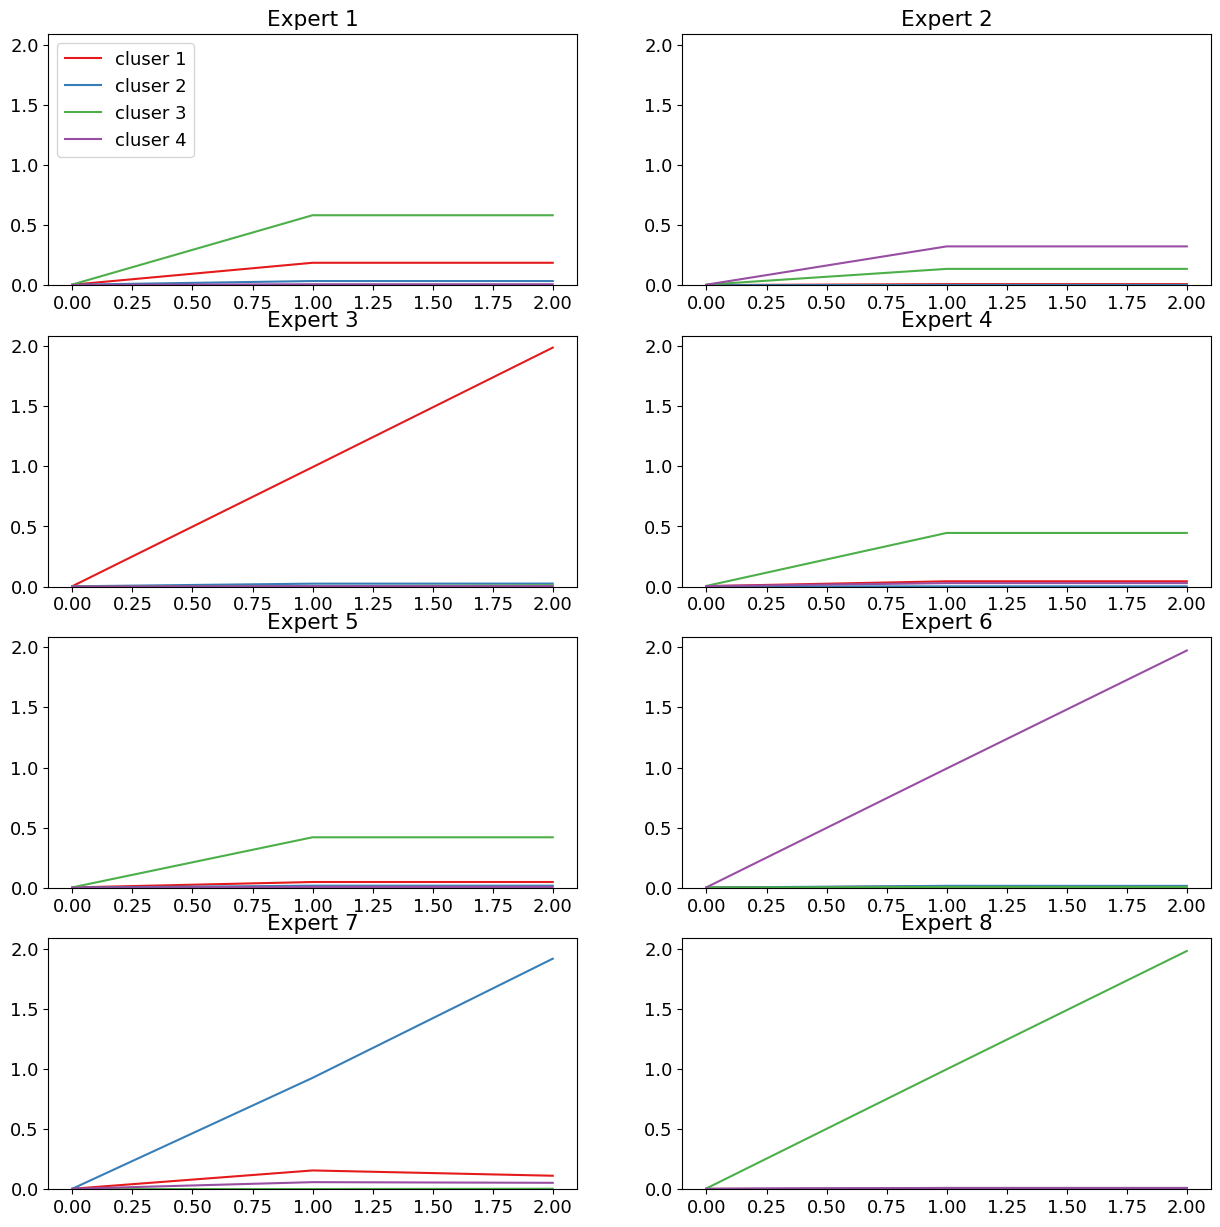

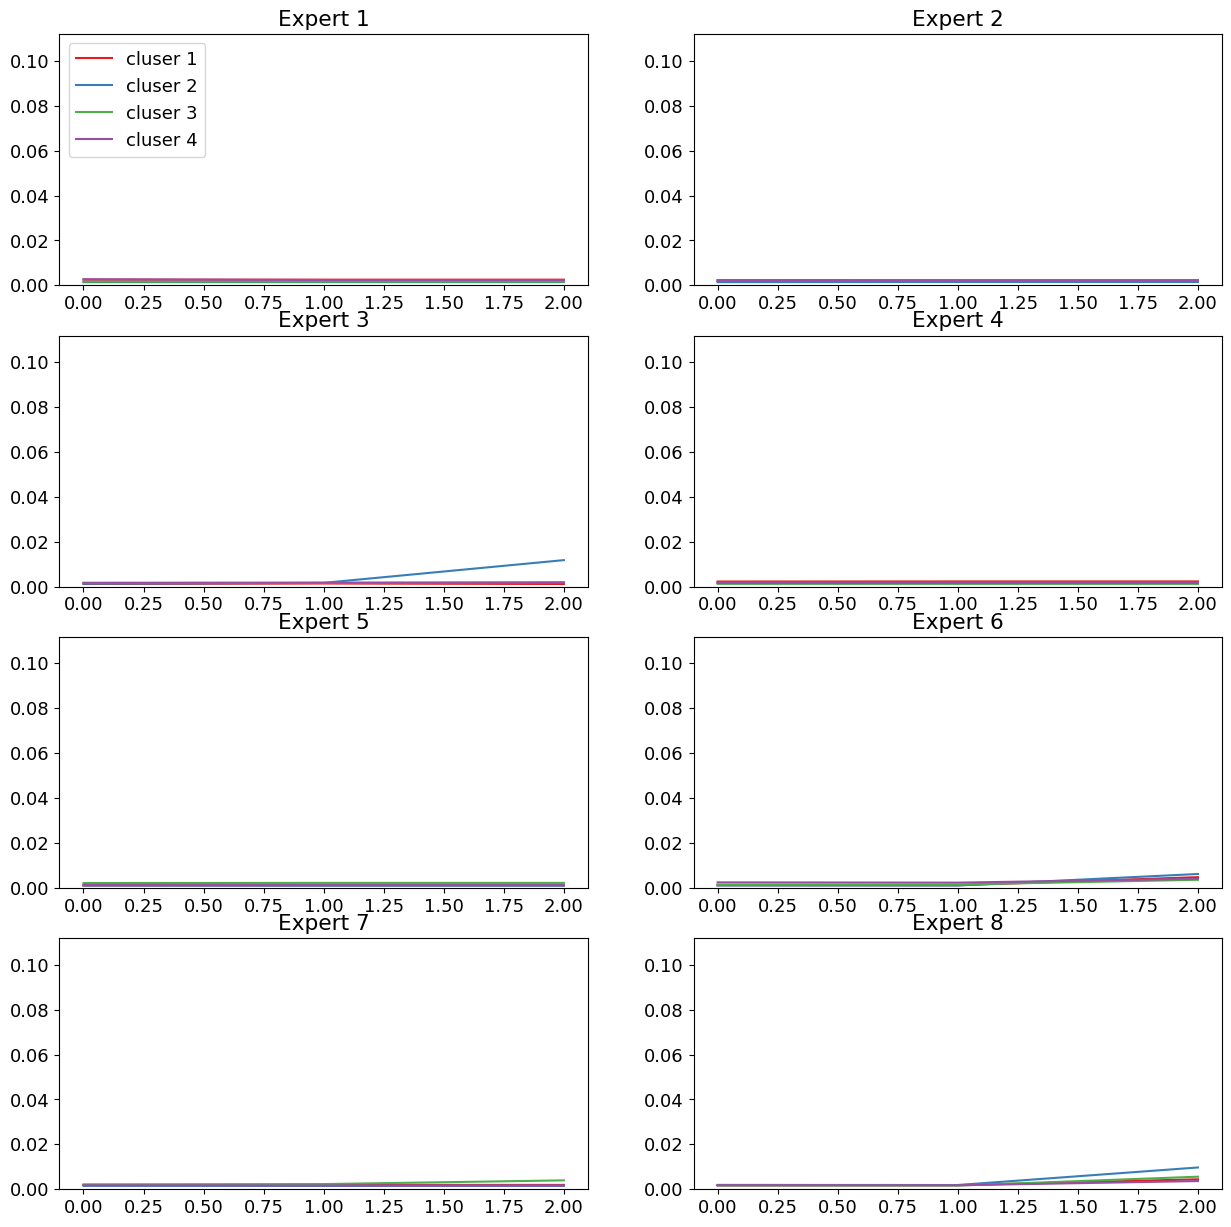

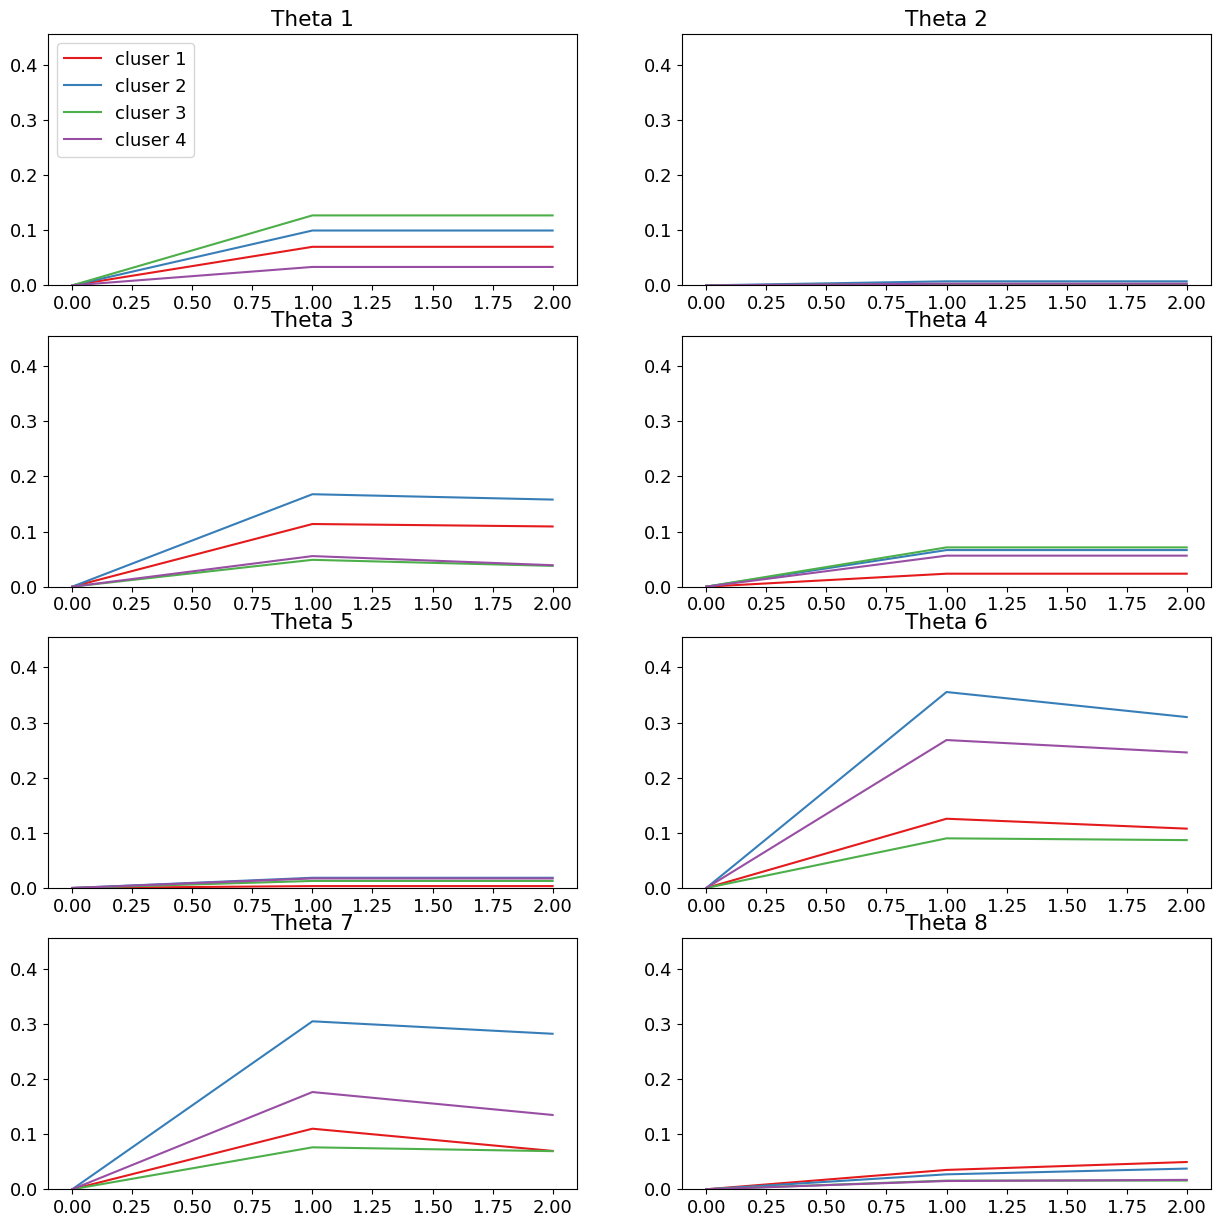

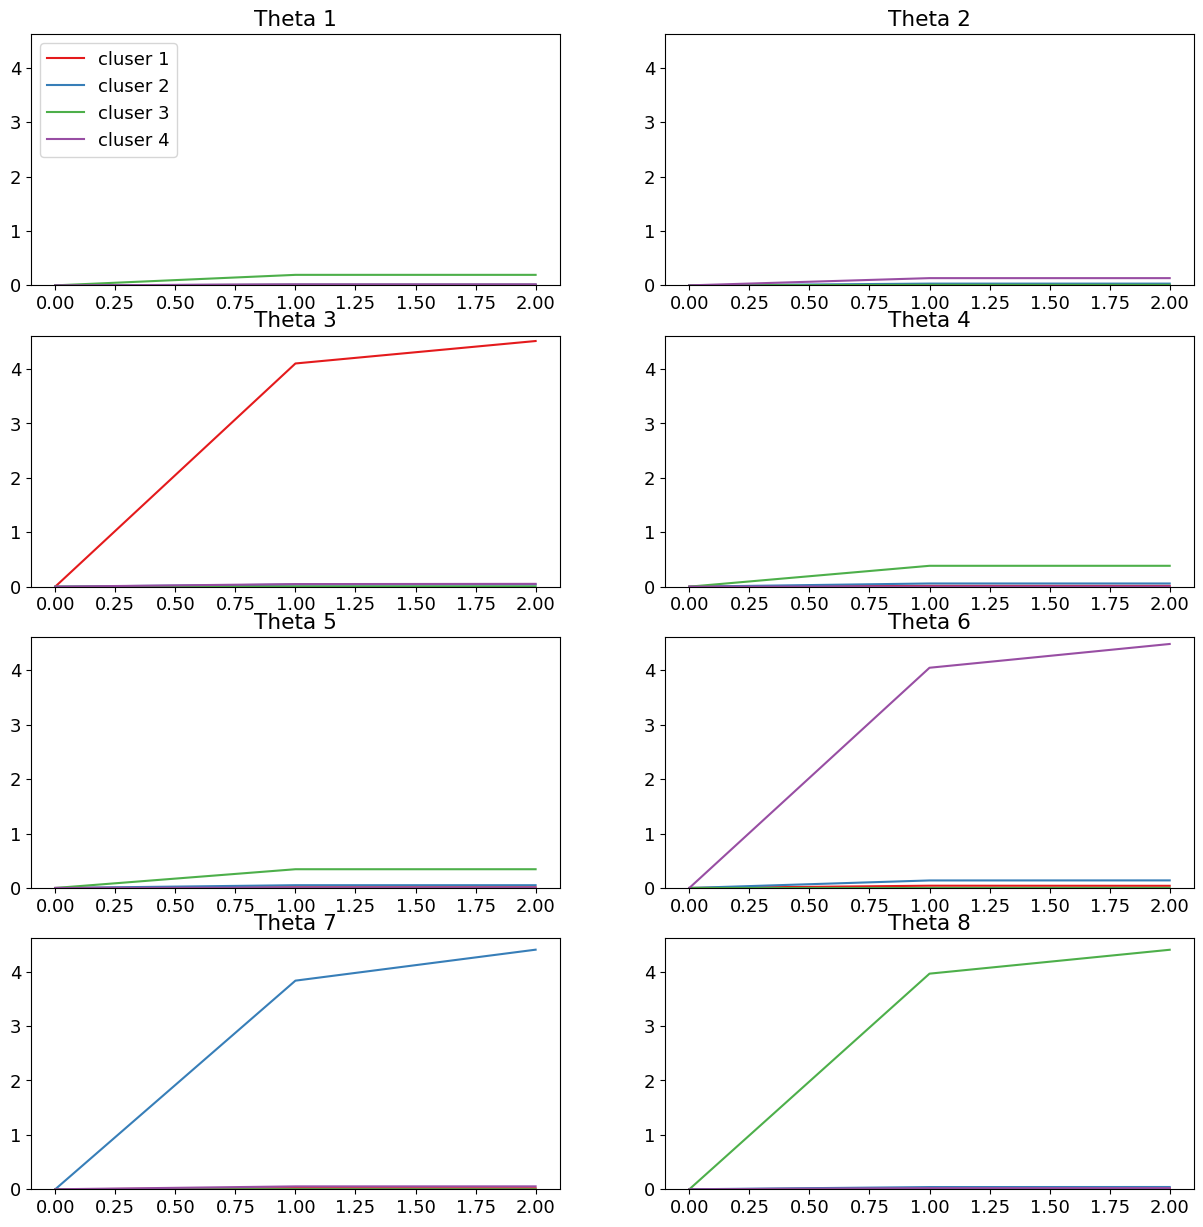

In [13]:
expert_feat = torch.tensor(expert_feat).cpu()
plot_expert_acc(expert_feat,0.1) 

expert_cent = torch.tensor(expert_cent).cpu()
plot_expert_acc(expert_cent,0.1) 

router_feat = torch.tensor(router_feat).cpu()
plot_router_acc(router_feat,0.1) 

router_cent = torch.tensor(router_cent).cpu()
plot_router_acc(router_cent,0.1) 

In [14]:
acc_list, ent_list = [], []
entropy_records = []

for i in range(10):    
    num_epochs = 501

    nonlinear_mixture = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=True).cuda() #input_dim, out_channel (m), cluter_num, patch_num
    criterion = torch.nn.CrossEntropyLoss()
    
    optimizer = NormalizedGD(nonlinear_mixture.models.parameters(), lr=0.001)
    optimizer2 = torch.optim.SGD(nonlinear_mixture.router.parameters(), lr=0.1)

    _, _, _, _, _, entropy_record = train(nonlinear_mixture, criterion, training_data, training_labels, 
                                          [optimizer,optimizer2], num_epochs, plot=False, verbose=False)
    ent_list.append(entropy_record[-1])

    acc = test(nonlinear_mixture, criterion, test_data, test_labels)
    acc_list.append(acc)
    
    entropy_records.append(torch.stack(entropy_record))
    
print()
print(f"Average test accuracy: {round(np.mean(acc_list),2)}.")
print(f"Standard deviation: {round(np.std(acc_list),2)}")
print()
print(f"Average dispatch entropy {round(np.mean(torch.stack(ent_list).cpu().numpy()),3)}.")
print(f"Standard deviation: {round(np.std(torch.stack(ent_list).cpu().numpy()),3)}")

Finished Training
Accuracy of the network on the 16000 test images: 99.7812 %
Finished Training
Accuracy of the network on the 16000 test images: 99.9688 %
Finished Training
Accuracy of the network on the 16000 test images: 98.8375 %
Finished Training
Accuracy of the network on the 16000 test images: 98.0938 %
Finished Training
Accuracy of the network on the 16000 test images: 99.5500 %
Finished Training
Accuracy of the network on the 16000 test images: 99.6625 %
Finished Training
Accuracy of the network on the 16000 test images: 99.4125 %
Finished Training
Accuracy of the network on the 16000 test images: 99.5250 %
Finished Training
Accuracy of the network on the 16000 test images: 99.7375 %
Finished Training
Accuracy of the network on the 16000 test images: 100.0000 %

Average test accuracy: 99.46.
Standard deviation: 0.55

Average dispatch entropy 0.09799999743700027.
Standard deviation: 0.08799999952316284


### Mix of Linear

In [15]:
linear_mixture = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=False).cuda()
criterion = torch.nn.CrossEntropyLoss()

_, s, _ = linear_mixture(training_data)
print(s.squeeze(-1).sum(dim=0))

optimizer = NormalizedGD(linear_mixture.models.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(linear_mixture.router.parameters(), lr=0.1) 

expert_feat, expert_cent, router_feat, router_cent, select, _ = train(linear_mixture, criterion, training_data, training_labels, 
                                                           [optimizer,optimizer2], num_epochs, plot=True)
print(select.squeeze(-1).sum(dim=0))

test(linear_mixture, criterion, training_data, training_labels)
test(linear_mixture, criterion, test_data, test_labels)

print(select[train_cluster_idx[0]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[1]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[2]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[3]].squeeze(-1).sum(dim=0).to(torch.long))

tensor([2082., 1920., 2044., 2065., 1965., 1983., 1997., 1944.],
       device='cuda:0')
Epoch 1 --- loss: 0.693
Epoch 101 --- loss: 0.365
Epoch 201 --- loss: 0.366
Epoch 301 --- loss: 0.368
Epoch 401 --- loss: 0.370
Epoch 501 --- loss: 0.371
Finished Training
tensor([ 148.,    0., 5589.,    0., 3958.,    0.,  745., 5560.],
       device='cuda:0')
Accuracy of the network on the 16000 test images: 94.1937 %
Accuracy of the network on the 16000 test images: 92.8750 %
tensor([   1,    0, 1968,    0,  516,    0,    3, 1547], device='cuda:0')
tensor([   0,    0, 1051,    0, 1092,    0,    0, 1856], device='cuda:0')
tensor([  10,    0, 1292,    0, 1234,    0,  404, 1066], device='cuda:0')
tensor([ 137,    0, 1278,    0, 1116,    0,  338, 1091], device='cuda:0')


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_29480\3318253049.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_acc = torch.tensor(expert_acc).squeeze(-1)


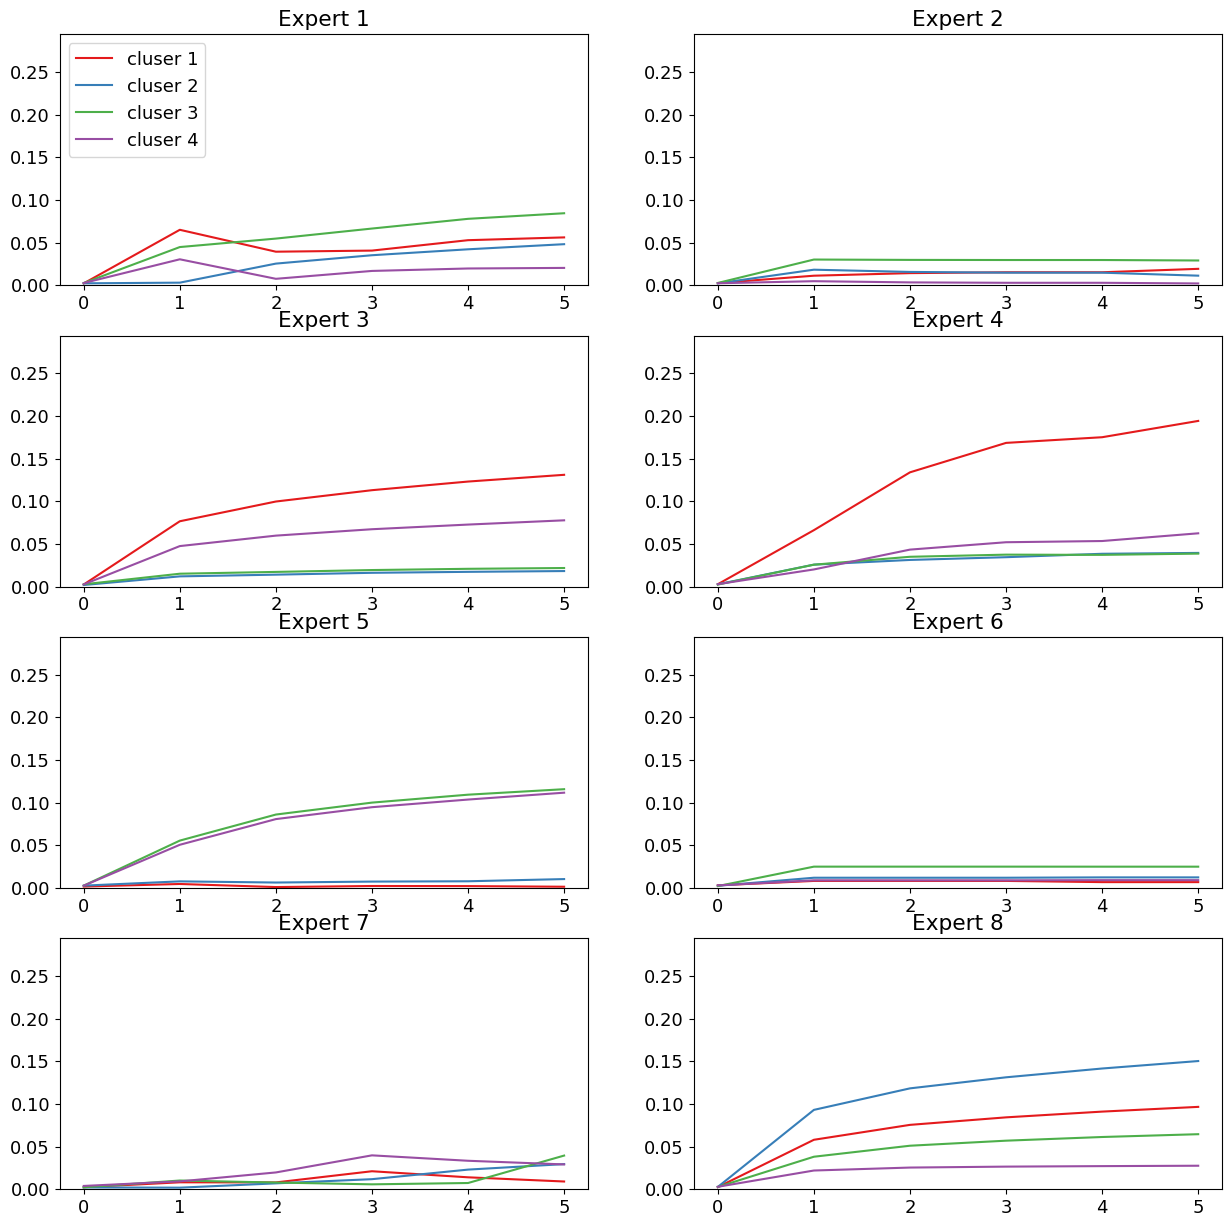

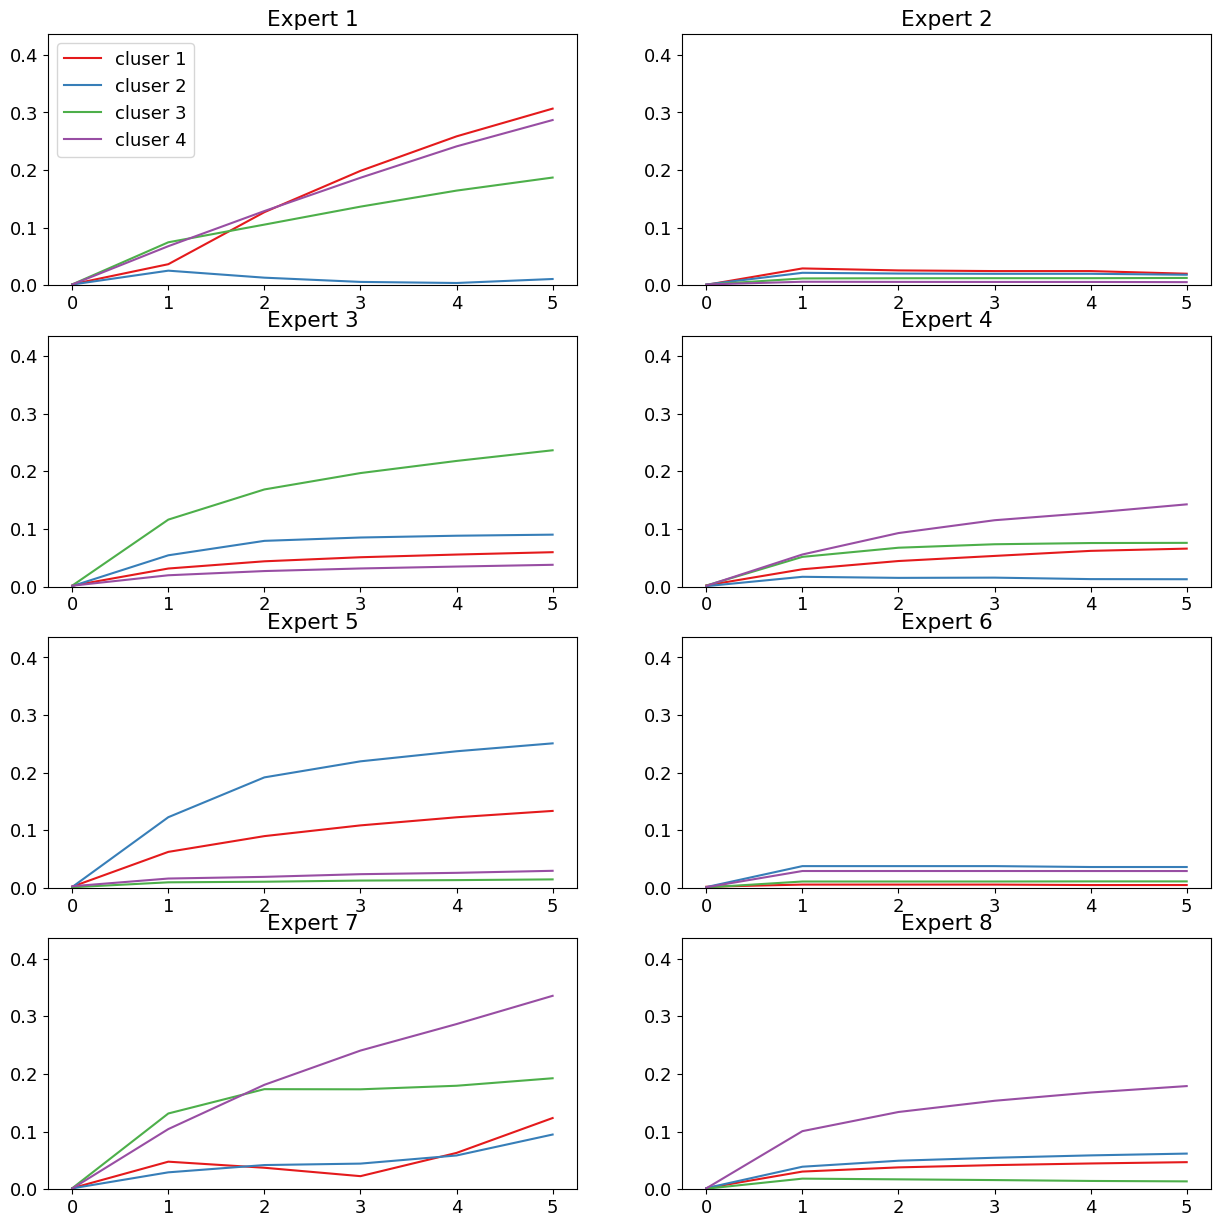

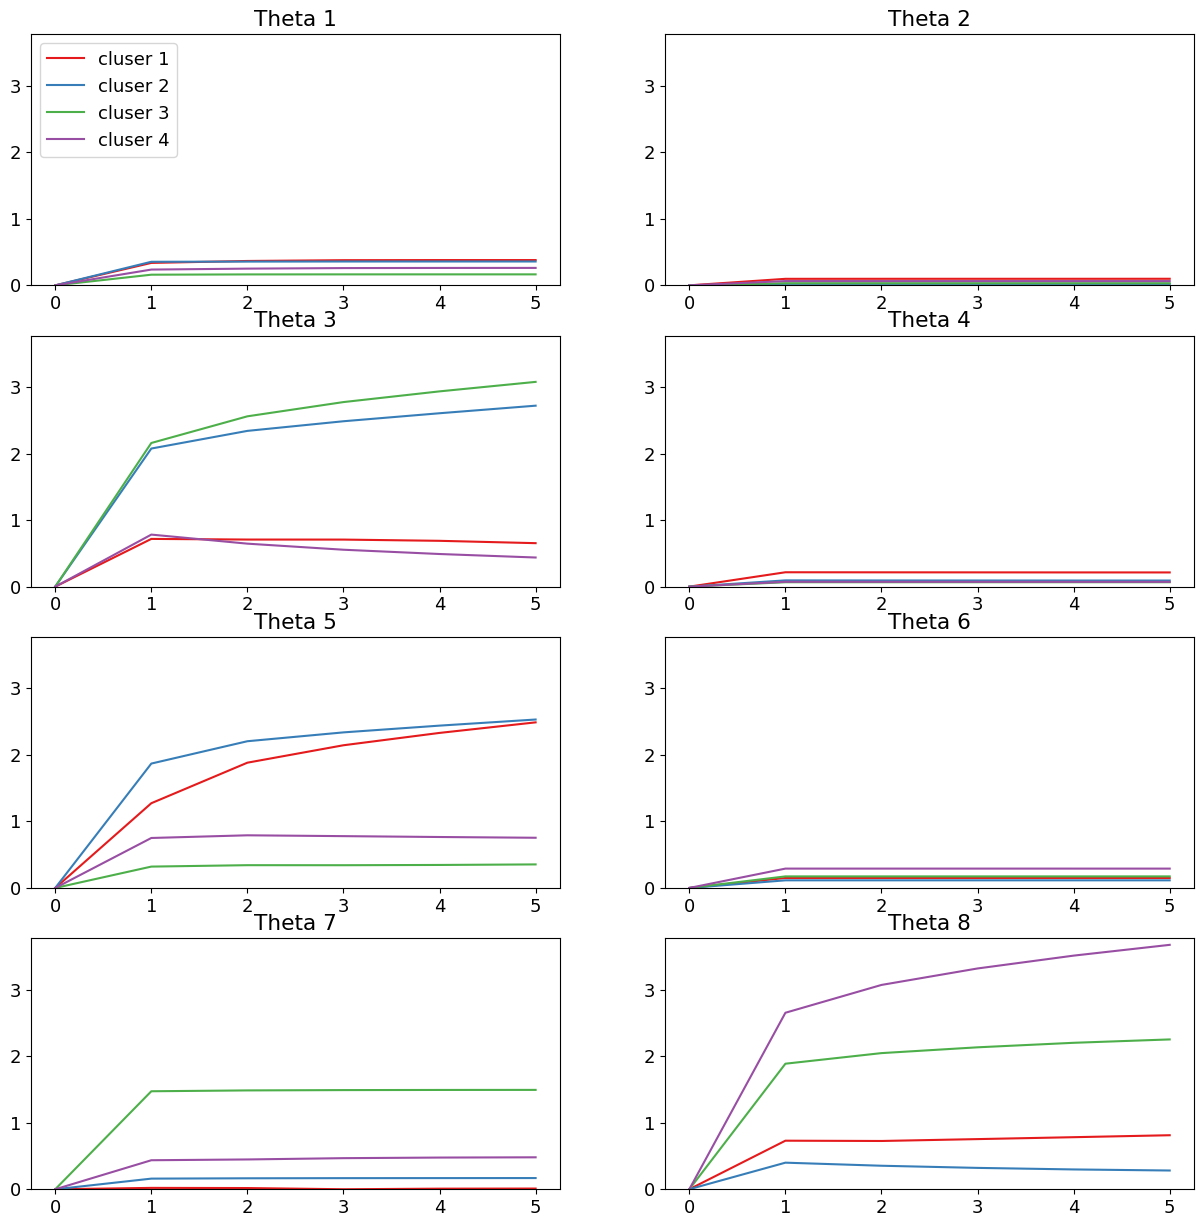

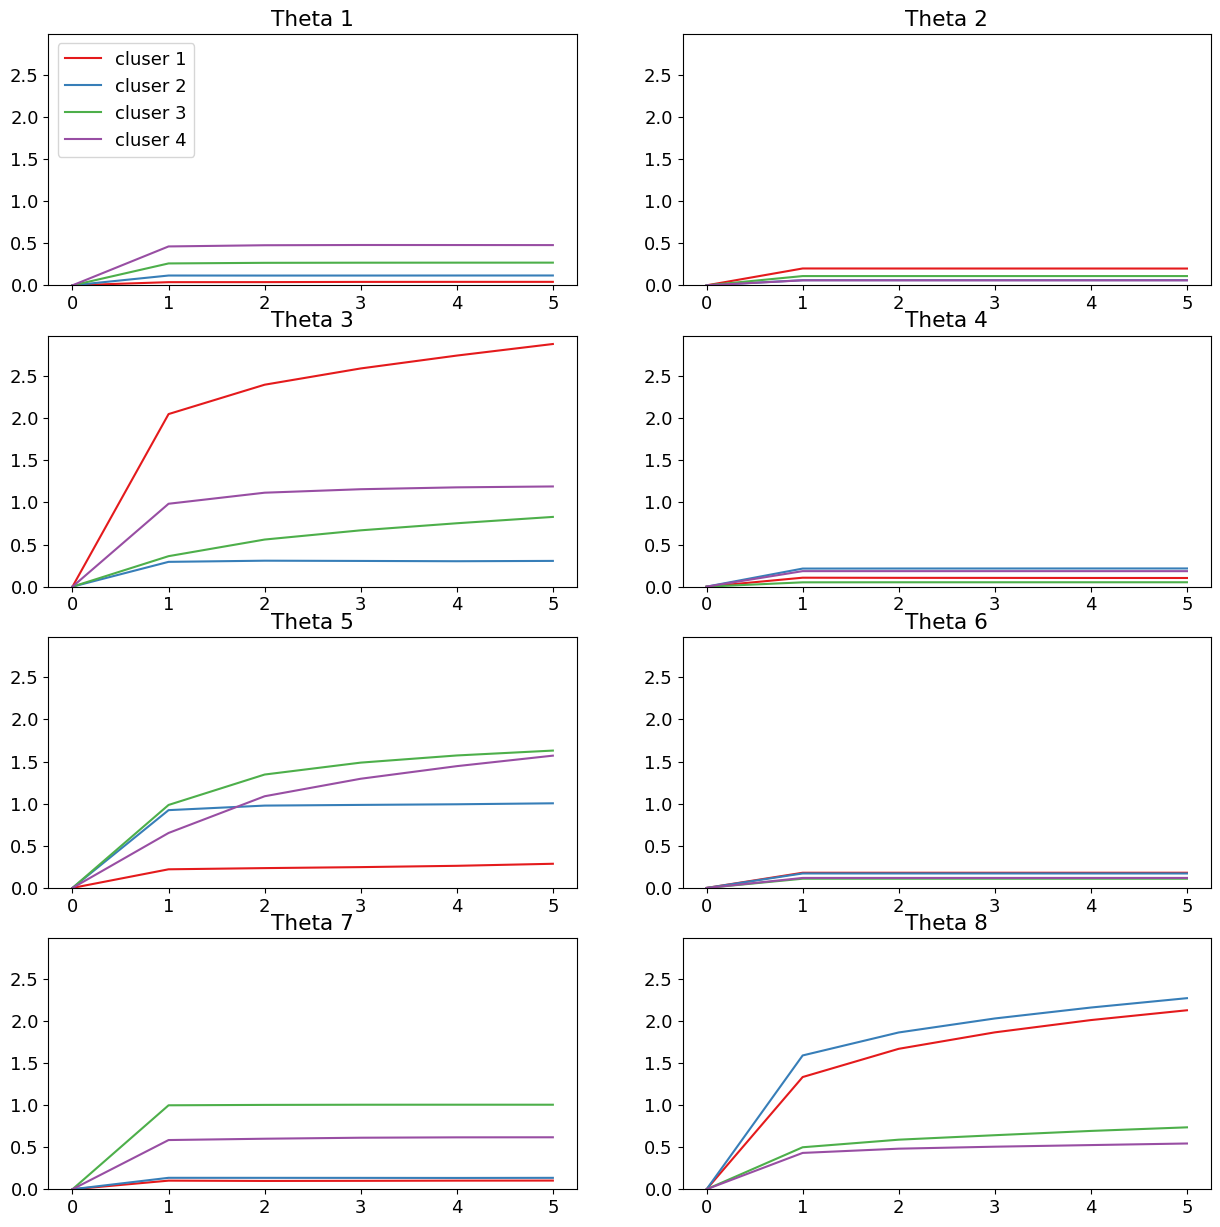

In [16]:
expert_feat = torch.tensor(expert_feat).cpu()
plot_expert_acc(expert_feat,0.1) 

expert_cent = torch.tensor(expert_cent).cpu()
plot_expert_acc(expert_cent,0.1)

router_feat = torch.tensor(router_feat).cpu()
plot_router_acc(router_feat,0.1) 

router_cent = torch.tensor(router_cent).cpu()
plot_router_acc(router_cent,0.1) 

In [17]:
acc_list, ent_list = [], []
entropy_records = []

for i in range(10):    
    num_epochs = 501

    linear_mixture = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=False).cuda() 
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = NormalizedGD(linear_mixture.models.parameters(), lr=0.001)
    optimizer2 = torch.optim.SGD(linear_mixture.router.parameters(), lr=0.1) 

    _, _, _, _, _, entropy_record = train(linear_mixture, criterion, training_data, training_labels, 
                                          [optimizer,optimizer2], num_epochs, plot=False, verbose=False)
    ent_list.append(entropy_record[-1])

    acc = test(linear_mixture, criterion, test_data, test_labels)
    acc_list.append(acc)
    
    entropy_records.append(torch.stack(entropy_record))
    
print()
print(f"Average test accuracy: {round(np.mean(acc_list),2)}.")
print(f"Standard deviation: {round(np.std(acc_list),2)}")
print()
print(f"Average dispatch entropy {round(np.mean(torch.stack(ent_list).cpu().numpy()),3)}.")
print(f"Standard deviation: {round(np.std(torch.stack(ent_list).cpu().numpy()),3)}")

Finished Training
Accuracy of the network on the 16000 test images: 95.6625 %
Finished Training
Accuracy of the network on the 16000 test images: 91.8688 %
Finished Training
Accuracy of the network on the 16000 test images: 88.9437 %
Finished Training
Accuracy of the network on the 16000 test images: 92.0625 %
Finished Training
Accuracy of the network on the 16000 test images: 95.3312 %
Finished Training
Accuracy of the network on the 16000 test images: 91.0812 %
Finished Training
Accuracy of the network on the 16000 test images: 95.8438 %
Finished Training
Accuracy of the network on the 16000 test images: 92.4250 %
Finished Training
Accuracy of the network on the 16000 test images: 92.6000 %
Finished Training
Accuracy of the network on the 16000 test images: 94.1312 %

Average test accuracy: 93.0.
Standard deviation: 2.11

Average dispatch entropy 1.2999999523162842.
Standard deviation: 0.04399999976158142


### Single (128 neurons)

In [18]:
num_epochs = 801

linear_single = ConvNet(200, 64, PATCH_NUM, small=False, nonlinear=False).cuda() 
criterion = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(linear_single.parameters(), lr=0.003, weight_decay=5e-4) 
train_single(linear_single, criterion, training_data, training_labels, [optimizer], num_epochs)

test_single(linear_single, criterion, training_data, training_labels)
test_single(linear_single, criterion, test_data, test_labels)

Epoch 1 --- loss: 12.976
Epoch 101 --- loss: 0.592
Epoch 201 --- loss: 0.586
Epoch 301 --- loss: 0.643
Epoch 401 --- loss: 0.668
Epoch 501 --- loss: 0.683
Finished Training
Accuracy of the network on the 16000 test images: 68.3688 %
Accuracy of the network on the 16000 test images: 67.6937 %


67.69375

In [19]:
nonlinear_single = ConvNet(200, 64, PATCH_NUM, small=False, nonlinear=True).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(nonlinear_single.parameters(), lr=0.01, weight_decay=5e-4) 
train_single(nonlinear_single, criterion, training_data, training_labels, 
                                                           [optimizer], num_epochs)

test_single(nonlinear_single, criterion, training_data, training_labels)
test_single(nonlinear_single, criterion, test_data, test_labels)

Epoch 1 --- loss: 115.106
Epoch 101 --- loss: 2.341
Epoch 201 --- loss: 0.758
Epoch 301 --- loss: 0.353
Epoch 401 --- loss: 0.351
Epoch 501 --- loss: 0.196
Finished Training
Accuracy of the network on the 16000 test images: 91.1750 %
Accuracy of the network on the 16000 test images: 78.8625 %


78.8625

### Single (512 neurons)

In [20]:
linear_single = ConvNet(200, 256, PATCH_NUM, small=False, nonlinear=False).cuda() 
criterion = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(linear_single.parameters(), lr=0.003, weight_decay=5e-4) 
train_single(linear_single, criterion, training_data, training_labels, [optimizer], num_epochs)

test_single(linear_single, criterion, training_data, training_labels)
test_single(linear_single, criterion, test_data, test_labels)

Epoch 1 --- loss: 18.126
Epoch 101 --- loss: 2.244
Epoch 201 --- loss: 2.105
Epoch 301 --- loss: 3.296
Epoch 401 --- loss: 2.655
Epoch 501 --- loss: 1.536
Finished Training
Accuracy of the network on the 16000 test images: 71.6125 %
Accuracy of the network on the 16000 test images: 71.1750 %


71.175

In [21]:
nonlinear_single = ConvNet(200, 256, PATCH_NUM, small=False, nonlinear=True).cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(nonlinear_single.parameters(), lr=0.01, weight_decay=5e-4) 
train_single(nonlinear_single, criterion, training_data, training_labels, 
                                                           [optimizer], num_epochs)

test_single(nonlinear_single, criterion, training_data, training_labels)
test_single(nonlinear_single, criterion, test_data, test_labels)

Epoch 1 --- loss: 255.293
Epoch 101 --- loss: 4.865
Epoch 201 --- loss: 1.140
Epoch 301 --- loss: 0.336
Epoch 401 --- loss: 0.124
Epoch 501 --- loss: 0.026
Epoch 601 --- loss: 0.012
Epoch 701 --- loss: 0.007
Epoch 801 --- loss: 0.005
Finished Training
Accuracy of the network on the 16000 test images: 99.9938 %
Accuracy of the network on the 16000 test images: 73.0125 %


73.0125